In [3]:
from kbmod.reprojection_utils import correct_parallax_with_minimizer, correct_parallax_geometrically
from astropy.coordinates import EarthLocation, SkyCoord, solar_system_ephemeris
from astropy.time import Time
import numpy as np
import matplotlib.pyplot as plt

Configure an example observation at a given ra/dec and time


In [4]:
HELIOCENTRIC_DISTANCE = 50.0

icrs_ra1 = 173.74513571
icrs_dec1 = 73.43426475
icrs_time1 = Time("2023-03-20T16:00:00", format="isot", scale="utc")
sc1 = SkyCoord(ra=icrs_ra1, dec=icrs_dec1, unit="deg")

with solar_system_ephemeris.set("de432s"):
    eq_loc = EarthLocation.of_site("ctio")

Calculate the parallax correction using the scipy minimizer algorithm
Note that without bounds Scipy will default to `BFGS`, with bounds defaults to `L-BFGS-B`.

In [7]:
baseline_coord, baseline_geo_dist = correct_parallax_with_minimizer(
    coord=sc1,
    obstime=icrs_time1,
    point_on_earth=eq_loc,
    heliocentric_distance=HELIOCENTRIC_DISTANCE,
    method=None,
    use_bounds=True,
)

In [8]:
print(f"ra:{baseline_coord.ra.deg}, dec:{baseline_coord.dec.deg}, distance:{baseline_geo_dist}")

ra:174.1287630927495, dec:72.3371323377278, distance:49.70221976808989


Calculate the parallax correction using the exact geometric algorithm. This is only applicable for HELIOCENTRIC_DISTANCE values > 1 au.

In [9]:
geometric_coord, geometric_geo_dist = correct_parallax_geometrically(
    coord=sc1,
    obstime=icrs_time1,
    point_on_earth=eq_loc,
    heliocentric_distance=HELIOCENTRIC_DISTANCE,
)

In [10]:
print(f"ra:{geometric_coord.ra.deg}, dec:{geometric_coord.dec.deg}, distance:{geometric_geo_dist}")

ra:174.12876318802248, dec:72.33713204769207, distance:49.70220655358769


Note that the difference between the minimizer and exact approach is much less than 1 arcsec. Also note that the run time of the minimzer algorithm is between 30-120ms depending on the specific minimizer algorithm used, while the geometric approach runs in about 3ms.

In [18]:
arcsec_sep = baseline_coord.separation(geometric_coord).to("arcsec").value
print(f"Separation between minimizer and geometric algorithms: {arcsec_sep} arcsec")
print(
    f"Difference in distances minimizer and geometric algorithms: {np.abs(baseline_geo_dist - geometric_geo_dist)} au"
)

Separation between minimizer and geometric algorithms: 0.00011351972820642426 arcsec
Difference in distances minimizer and geometric algorithms: 7.718553057145527e-06 au


Here we compare the minimizer and geometric solutions for several heliocentric_distance guesses and 0-360 degrees ra.

In [13]:
min_heliocentric_distance = 20
max_heliocentric_distance = 51
heliocentric_distance_step = 10

min_ra = 0
max_ra = 361
ra_step = 10

with solar_system_ephemeris.set("de432s"):
    eq_loc = EarthLocation.of_site("ctio")

all_separations_geom = []
all_distance_diffs_geom = []

for heliocentric_distance in range(
    min_heliocentric_distance, max_heliocentric_distance, heliocentric_distance_step
):
    print(f"Working on heliocentric distance:{heliocentric_distance}")
    per_distance_separation_geom = []
    per_distance_earth_dist_diff_geom = []

    for ra in range(min_ra, max_ra, ra_step):

        icrs_ra1 = ra  # range of 0-360
        icrs_dec1 = 10.0  # perhaps set this to 10.
        icrs_time1 = Time("2023-03-20T16:00:00", format="isot", scale="utc")
        sc1 = SkyCoord(ra=icrs_ra1, dec=icrs_dec1, unit="deg")

        baseline_coord, baseline_geo_dist = correct_parallax_with_minimizer(
            coord=sc1,
            obstime=icrs_time1,
            point_on_earth=eq_loc,
            heliocentric_distance=heliocentric_distance,
            method=None,
            use_bounds=True,
        )

        geometric_coord, geometric_geo_dist = correct_parallax_geometrically(
            coord=sc1,
            obstime=icrs_time1,
            point_on_earth=eq_loc,
            heliocentric_distance=heliocentric_distance,
        )

        arcsec_sep = baseline_coord.separation(geometric_coord).to("arcsec").value
        per_distance_separation_geom.append(arcsec_sep)
        per_distance_earth_dist_diff_geom.append(np.abs(baseline_geo_dist - geometric_geo_dist))

    all_separations_geom.append(per_distance_separation_geom)
    all_distance_diffs_geom.append(per_distance_earth_dist_diff_geom)

Working on heliocentric distance:20
Working on heliocentric distance:30
Working on heliocentric distance:40
Working on heliocentric distance:50


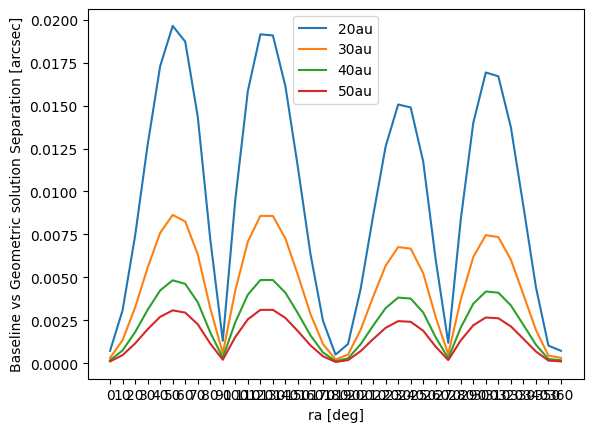

In [14]:
rng_obj = range(min_ra, max_ra, ra_step)
plt.plot(
    np.array(all_separations_geom).T,
    label=[
        f"{i}au"
        for i in range(min_heliocentric_distance, max_heliocentric_distance, heliocentric_distance_step)
    ],
)
plt.xticks(list(range(0, len(all_separations_geom[0]))), list(rng_obj))
plt.xlabel("ra [deg]")
plt.ylabel("Baseline vs Geometric solution Separation [arcsec]")
plt.legend()
plt.show()

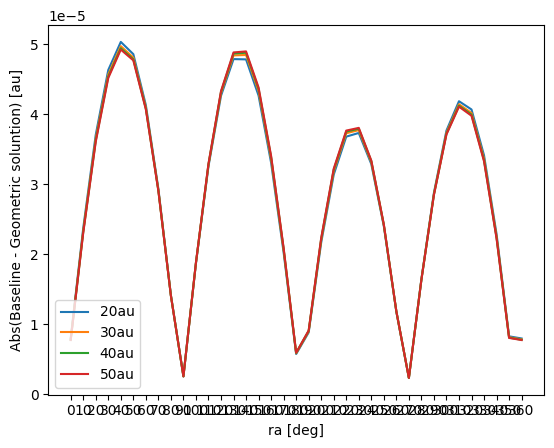

In [15]:
rng_obj = range(min_ra, max_ra, ra_step)

plt.plot(
    np.array(all_distance_diffs_geom).T,
    label=[
        f"{i}au"
        for i in range(min_heliocentric_distance, max_heliocentric_distance, heliocentric_distance_step)
    ],
)
plt.xticks(list(range(0, len(all_distance_diffs_geom[0]))), list(rng_obj))
plt.xlabel("ra [deg]")
plt.ylabel("Abs(Baseline - Geometric soluntion) [au]")
plt.legend()
plt.show()

For contrived observations taken at the equinox, we should find very specific values for corrected ra and dec. The following cell shows this to be true.

In [20]:
icrs_ra1 = 88.74513571
icrs_dec1 = 23.43426475
icrs_time1 = Time("2023-03-20T16:00:00", format="isot", scale="utc")

icrs_ra2 = 91.24261107
icrs_dec2 = 23.43437467
icrs_time2 = Time("2023-09-24T04:00:00", format="isot", scale="utc")

sc1 = SkyCoord(ra=icrs_ra1, dec=icrs_dec1, unit="deg")
sc2 = SkyCoord(ra=icrs_ra2, dec=icrs_dec2, unit="deg")

equinox_geo_dist = 50.00135417530472


corrected_coord1, _ = correct_parallax_with_minimizer(
    coord=sc1,
    obstime=icrs_time1,
    point_on_earth=eq_loc,
    heliocentric_distance=50.0,
    use_bounds=True,
)

expected_ra = 90.0
expected_dec = 23.43952556

print("Minimizer algorithm comparison 1: |calculated - expected|")
print(np.abs(corrected_coord1.ra.value - expected_ra))
print(np.abs(corrected_coord1.dec.value - expected_dec))

corrected_coord2, _ = correct_parallax_with_minimizer(
    coord=sc2,
    obstime=icrs_time2,
    point_on_earth=eq_loc,
    heliocentric_distance=50.0,
    use_bounds=True,
)

print("Minimizer algorithm comparison 2: |calculated - expected|")
print(np.abs(corrected_coord2.ra.value - expected_ra))
print(np.abs(corrected_coord2.dec.value - expected_dec))

corrected_coord3, _ = correct_parallax_geometrically(
    coord=sc1,
    obstime=icrs_time1,
    point_on_earth=eq_loc,
    heliocentric_distance=50.0,
)

expected_ra = 90.0
expected_dec = 23.43952556

print("Geometric algorithm comparison `2`: |calculated - expected|")
print(np.abs(corrected_coord3.ra.value - expected_ra))
print(np.abs(corrected_coord3.dec.value - expected_dec))

corrected_coord4, _ = correct_parallax_geometrically(
    coord=sc2,
    obstime=icrs_time2,
    point_on_earth=eq_loc,
    heliocentric_distance=50.0,
)

print("Geometric algorithm comparison 2: |calculated - expected|")
print(np.abs(corrected_coord4.ra.value - expected_ra))
print(np.abs(corrected_coord4.dec.value - expected_dec))

Minimizer algorithm comparison 1: |calculated - expected|
4.694584276876412e-09
3.4186946606951096e-09
Minimizer algorithm comparison 2: |calculated - expected|
4.944666898154537e-10
2.5229631717138545e-09
Geometric algorithm comparison `2`: |calculated - expected|
1.8828373526957876e-08
3.415927096739324e-09
Geometric algorithm comparison 2: |calculated - expected|
1.4868192010908388e-08
2.525659681396064e-09
